Key Points:

To be plotted a (multi)polygon must be in form: geopandas.geodataframe.GeoDataFrame

To run 'intersects' it must be a str representing a geojson geometry

To display on leaflet map must be a dict representing a geojson geometry

To use as mask for xarray 'clip' it must be a list (of coordinates)

In [30]:
#!pip install rioxarray
import dask.array as da
from pystac_client import Client
import leafmap
from datetime import datetime
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import numpy as np
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import geojson
import json
from geogif import dgif, gif
import pandas as pd
import shapely
from shapely.geometry import mapping


In [31]:
#!pip install stackstac==0.5.0 --upgrade 

In [32]:
# stackstac needs to be 0.5.0
# if it is not run !pip install stackstac==0.5.0 --upgrade  
# And restart kernal
# or maybe this works? "conda install -c conda-forge stackstac" in MPC terminal and then restart this kernal
import stackstac
stackstac.__version__

'0.5.0'

In [33]:
# Start by reading in shapefiles of veg class
# In this case it is a feature class of every patch of eucalyptus within a fire perimeter that's burned since 2002
Euc= gpd.read_file("Euc/Euc_Correct.shp")
# Read in Fire shapefile
Fires= gpd.read_file("Fires/Fires_Good.shp")

# Filter to only vegetation patches > 5 acres
EucList= Euc[Euc['Acres']>5]

# Select observations in 'FireList' where 'FIRE_NAME' is in 'EucList'
FireList = Fires[Fires['FIRE_NAME'].isin(EucList['FIRE_NAME'])]
FireList_sorted = FireList.sort_values(by='FIRE_NAME')
EucList_sorted = EucList.sort_values(by='FIRE_NAME')

# Change everything to 4326 and verify geometry is not in coordinates
Euc_4326 = EucList_sorted.to_crs(4326)
Fires_4326 = FireList_sorted.to_crs(4326)

Fires_4326.reset_index(drop=True, inplace=True)
Euc_4326.reset_index(drop=True, inplace=True)

In [34]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:45865' processes=4 threads=4, memory=32.00 GiB>

In [35]:
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
start_date = datetime(2002, 1, 1).isoformat()
end_date = datetime(2023, 12, 31).isoformat()
bbox = (-123.74286820900588, 36.79177481727697, -121.16108109963088, 38.82267288995824)

#We will clip to the study area to avoid grabbing pointless pictures of the ocean that would be included with bbbox
counties= gpd.read_file("Counties/counties.shp")

#However there are several steps necessary to get "counties" into the right format for the stacstack 'intersects' function

# The shapefile is in meters intstead of coordinates, so we have to start by giving it a crs
counties_4326 = counties.to_crs(4326)

# If it was a simpler shape, with fewer points you could turn counties_4326 into a geojson now. 
# But it needs to be a smaller file for the intersects function to accept it
# So we'll start by dissolving the individual counties into one geometry
counties_combined = counties_4326.unary_union

# and getting the convex hull
counties_convex = counties_combined.convex_hull

# convert this back into a geopandas geodataframe
convex_df = gpd.GeoDataFrame(geometry=[counties_convex])
convex_df.set_crs(4326)

# Turn it back ito a geojson
convex_json = convex_df.to_json()

# However it is a feature collection, but needs to be a (multi-) point, line, or feature
convex_json

# so we will extract the geometry
geometry_part = json.loads(convex_json)["features"][0]["geometry"]

# Create a GeoJSON string (representing a polygon) with the geometry part
geometry_geojson = json.dumps(geometry_part)

# finally this can be used by the intersect function
SA= geometry_geojson

In [36]:
catalog = pystac_client.Client.open(api_url)

search = catalog.search(
    datetime=f"{start_date}/{end_date}",
    collections=["landsat-c2-l2"],
    intersects=SA,
    #bbox=bbox,
    query=["eo:cloud_cover<2"],
    max_items=2000
)

# pull out items from search
items = pc.sign(search)

# Initialize image stack
stack = stackstac.stack(items, bounds_latlon=bbox)

stack.sel(band=["nir08", "swir16", "red","green","blue"])

<xarray.DataArray 'stackstac-5c0f777728e9d76e25ea46ccc64d0d7f' (time: 1369,
                                                                band: 5,
                                                                y: 7557, x: 7679)>
dask.array<getitem, shape=(1369, 5, 7557, 7679), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2002-02-28T18:40:49.42...
    id                           (time) <U31 'LE07_L2SP_045033_20020228_02_T1...
  * band                         (band) <U13 'nir08' 'swir16' ... 'green' 'blue'
  * x                            (x) float64 4.337e+05 4.337e+05 ... 6.64e+05
  * y                            (y) float64 4.299e+06 4.299e+06 ... 4.072e+06
    description                  (band) object None None None None None
    ...                           ...
    title                        (band) object 'Near Infrared Band 0.8' ... '...
    classification:bitfields     (band) object None None None None None
    common_name                  (band) object None None None None None
    center_wavelength            (band) object None None None None None
    full_width_half_max          (band) object None None None None None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(433710.0, 4072020.0, 664080.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 433710.00|\n| 0.00,-30.00, 4298730.00|\n| 0.0...
    resolution:  30.0

In [37]:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

bin(bitmask)

qa = stack.sel(band="qa_pixel").astype("uint16")
bad = qa & bitmask  # just look at those 4 bits

good = stack.where(bad == 0)  # mask pixels where any one of those bits are set

In [38]:
# Define band combinations
nir = good.sel(band="nir08")
swir = good.sel(band="swir16")
nbr = (nir-swir)/((nir+swir)+.00001)
#nbr
rgb = good.sel(band = ['red','green','blue'])
#rgb

# compress temporal resolution to monthly
monthlyNBR = nbr.resample(time="MS").median("time", keep_attrs=True)
monthlyRGB = rgb.resample(time="MS").median("time", keep_attrs=True)


# ensure correct crs and view your stack
monthlyNBR = monthlyNBR.rio.write_crs("32610", inplace=True)
monthlyRGB = monthlyRGB.rio.write_crs("32610", inplace=True)

#Change EucAreas and FireAreas CRS to match monthly
Fires32610=Fires_4326.to_crs(32610)
Euc32610=Euc_4326.to_crs(32610)

## Code to make GIFs
##### Run all above before setting variables and running functions below 

<Axes: >

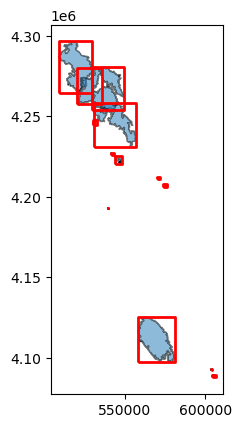

In [39]:
# Add bbox around each fire as a column

# Create a GeoDataFrame for bounding boxes
bbox_df = gpd.GeoDataFrame(geometry=Fires32610.envelope)

# If you want to add the bounding boxes as a new column in the existing GeoDataFrame
Fires32610['bounding_box'] = Fires32610.envelope

# If you want to visualize the result
ax = Fires32610.plot(alpha=0.5, edgecolor='k')  # Original polygons
bbox_df.boundary.plot(ax=ax, color=None, edgecolor='r', linewidth=2)  # Bounding boxes in red

In [17]:
# Print list of fires to reference for index
Fires32610

YEAR_ STATE AGENCY UNIT_ID              FIRE_NAME   INC_NUM  ALARM_DATE  \
0   2017    CA    CDF     LNU                     37  00002957  2017-10-09   
1   2020    CA    CDF     CZU  CZU LIGHTNING COMPLEX  00005205  2020-08-16   
2   2021    CA    CDF     CZU                FREEDOM  00000489  2021-01-19   
3   2020    CA    CDF     LNU                  GLASS  00015497  2020-09-27   
4   2004    CA    CDF     SCU                HIGHWAY  00003485  2004-06-25   
5   2019    CA    CDF     LNU                KINCADE  00019376  2019-10-23   
6   2013    CA    CDF     LNU              LAKEVILLE  00006147  2013-07-26   
7   2017    CA    CDF     LNU                   NUNS  00010049  2017-10-08   
8   2017    CA    CDF     LNU               PRESSLEY  00010049  2017-10-08   
9   2022    CA    CDF     SCU                 SCENIC  00004548  2022-06-23   
10  2004    CA    NPS     GNP                    TAM  00000003  2004-05-09   
11  2008    CA    CDF     CZU                TRABING    005581  2008-06-20   
12  2017    CA    CDF     LNU                  TUBBS  00010045  2017-10-08   

     CONT_DATE  CAUSE                                           COMMENTS  ...  \
0   2017-10-16     11  LFB8.  DIGITIZED FROM DIGITALGLOBE (MAXAR) IMA...  ...   
1   2020-09-24      1                                                NaN  ...   
2   2021-01-22     11                                                NaN  ...   
3   2020-10-20     14                                         J. Baldwin  ...   
4   2004-06-28      2                                                NaN  ...   
5   2019-11-10     11                                                NaN  ...   
6   2013-07-27      2                                                NaN  ...   
7   2017-10-31     14  Nuns,Partrick, Adobe, Norrbom and Pressley mer...  ...   
8   2017-10-15     14                                   Merged into Nuns  ...   
9   2022-06-23     10                                                NaN  ...   
10  2004-05-18     14                                                NaN  ...   
11  2008-06-22     10                            75 structures destroyed  ...   
12  2017-11-01     14                                                NaN  ...   

    C_METHOD  OBJECTIVE  FIRE_NUM             COMPLEX_NA COMPLEX_IN  \
0          4          1       NaN                    NaN        NaN   
1          7          1       NaN  CZU LIGHTNING COMPLEX   00005205   
2          1          1       NaN                    NaN        NaN   
3          7          1       NaN                    NaN        NaN   
4          1          1  00000181                    NaN        NaN   
5          1          1       NaN                    NaN        NaN   
6          2          1       NaN                    NaN        NaN   
7          3          1       NaN   SOUTHERN LNU COMPLEX   00010105   
8          7          1       NaN   SOUTHERN LNU COMPLEX   00010105   
9          1          1       NaN                    NaN        NaN   
10         1          1  00000003                    NaN        NaN   
11         1          1       NaN                    NaN        NaN   
12         3          1       NaN    CENTRAL LNU COMPLEX   00010104   

                                 IRWINID     Shape_Leng    Shape_Area  \
0   F570C977-2D96-4BB0-A146-52D1A32FA87D   46336.050945  1.057459e+07   
1                                    NaN  255052.193260  5.523185e+08   
2                                    NaN    4130.554410  2.112959e+05   
3                                    NaN  272074.173454  4.470432e+08   
4                                    NaN   10317.778914  4.080267e+06   
5                                    NaN  238568.856409  5.171126e+08   
6                                    NaN    8412.064209  1.166756e+06   
7                                    NaN  305483.095957  3.680012e+08   
8                                    NaN   22361.236288  5.220480e+06   
9   0ef3aa7b-6f57-4b9d-9ffc-07de6bfd0673    5501.8

In [16]:
# This function will give frame by frame of monthly NBR and RGB for a fire bbox specified in the index. 
# This is helpfulf for troubleshooting unexpected NBR mean values in graphs above,
# or for the creation of GIFs

def Fire_Area_TS(index, data_type, clean= True):
    # Get fire information by index
    row = Fires32610.iloc[index]
    fire_name = row['FIRE_NAME']
    fire_breakout_time = pd.to_datetime(row['ALARM_DATE'])
    
    # Set the time range based on the ALARM date
    start_time = fire_breakout_time - pd.DateOffset(months=3)
    end_time = fire_breakout_time + pd.DateOffset(months=24)
    
    # Get 'bounding_box' as GeoPandas geometry
    bounding_box = row['bounding_box']
    bounding_box_geojson = geojson.dumps(bounding_box.__geo_interface__)
    bboxClipGeometry = [geojson.loads(bounding_box_geojson)]
    
    # Clip the xarray dataarray with the fire and vegetation geometries
    if data_type == 'NBR':
        bboxClip = monthlyNBR.rio.clip(bboxClipGeometry)
    elif data_type == 'RGB':
        bboxClip = monthlyRGB.rio.clip(bboxClipGeometry)
    else:
        raise ValueError("Invalid data_type. Use 'NBR' or 'RGB'.")

    # Select the desired time range
    bboxTimeClip = bboxClip.sel(time=slice(start_time, end_time))

    if clean == True:
    # Fill NaN values and calculate mean
        bboxTimeClip=bboxTimeClip[0:].ffill("time").bfill("time")
        #bboxTimeClip = bboxTimeClip.ffill("time")[1:]
    
    # save timeseries locally in order to display individually, and compute to actually load
    bbox_ts = bboxTimeClip.persist()
    bbox_ts_local = bbox_ts.compute()
    
    # initiate time series plot and label NBR scale bar
    if data_type == 'NBR':
        cbar_kwargs = {'label': 'NBR'}
        bbox_ts_local.plot.imshow(col="time", col_wrap=5, robust=True, cbar_kwargs = cbar_kwargs)
    elif data_type == 'RGB':
        bbox_ts_local.plot.imshow(col="time", rgb="band", col_wrap=5, robust=True)
    
    # Display title on top of time series
    if clean == True:
        title_text = f"{fire_name.title()} Fire {data_type} Time Series: {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')} (forward filled)"
    else:
        title_text = f"{fire_name.title()} Fire {data_type} Time Series: {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')} (not forward filled)"

    plt.suptitle(title_text, fontsize=16, y=1.02)
    # Create a title for the plot
    plt.suptitle(title_text, fontsize=16, y=1.02)
    plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: Run

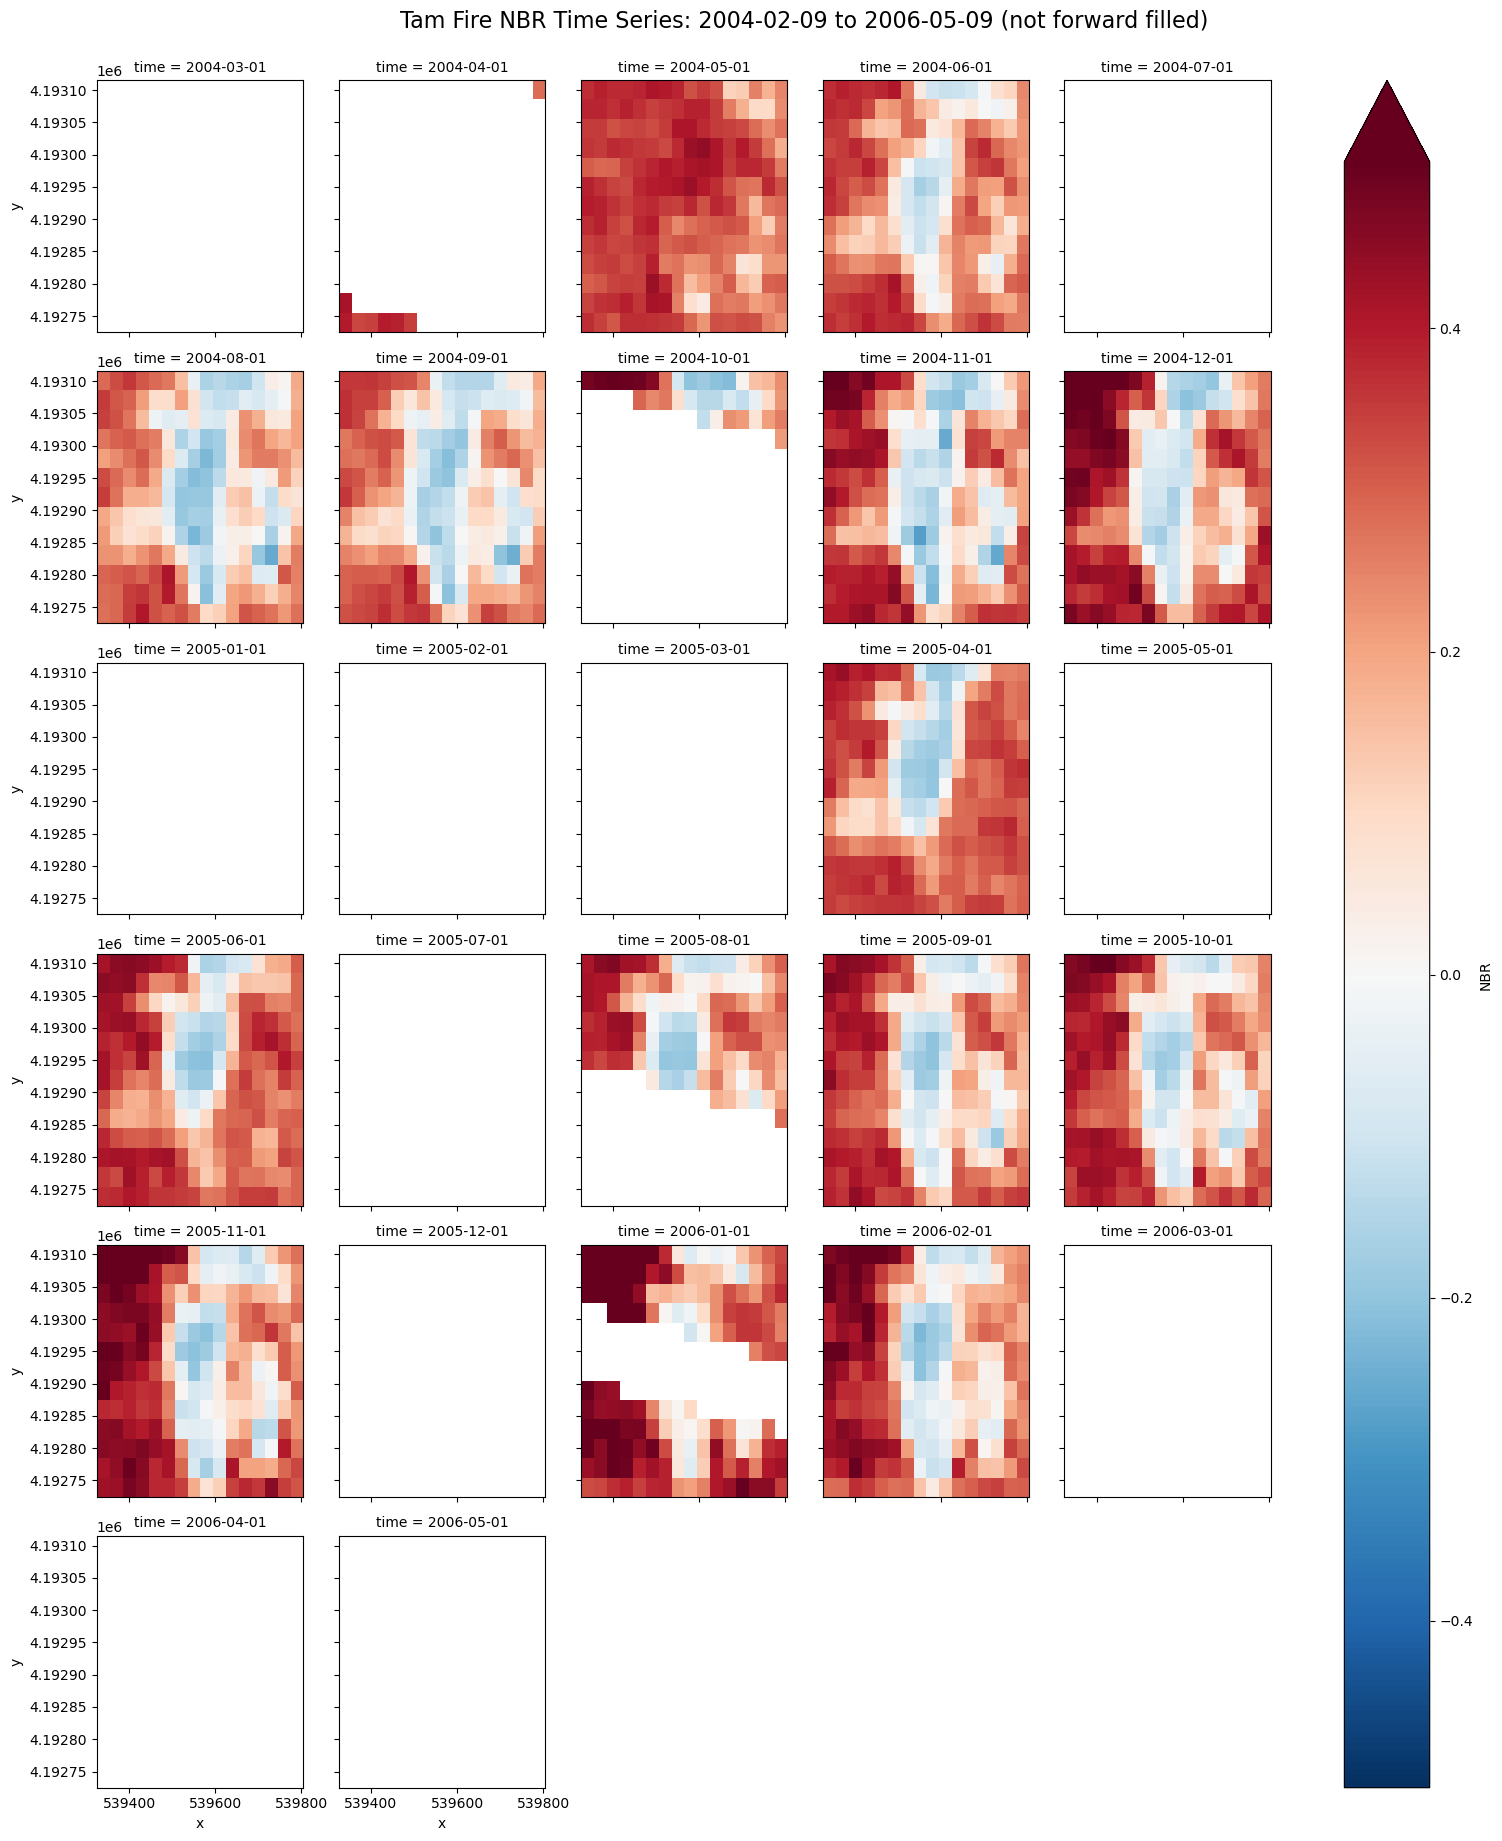

In [18]:
# Set variables
# index is an integer from 0 to 12 corresponding to index of fire from Fires32610
# data_type is either "NBR" or "RGB" cleaned defaults to True. Set to False to see which months lack good imagery
Fire_Area_TS(10,'NBR', False)

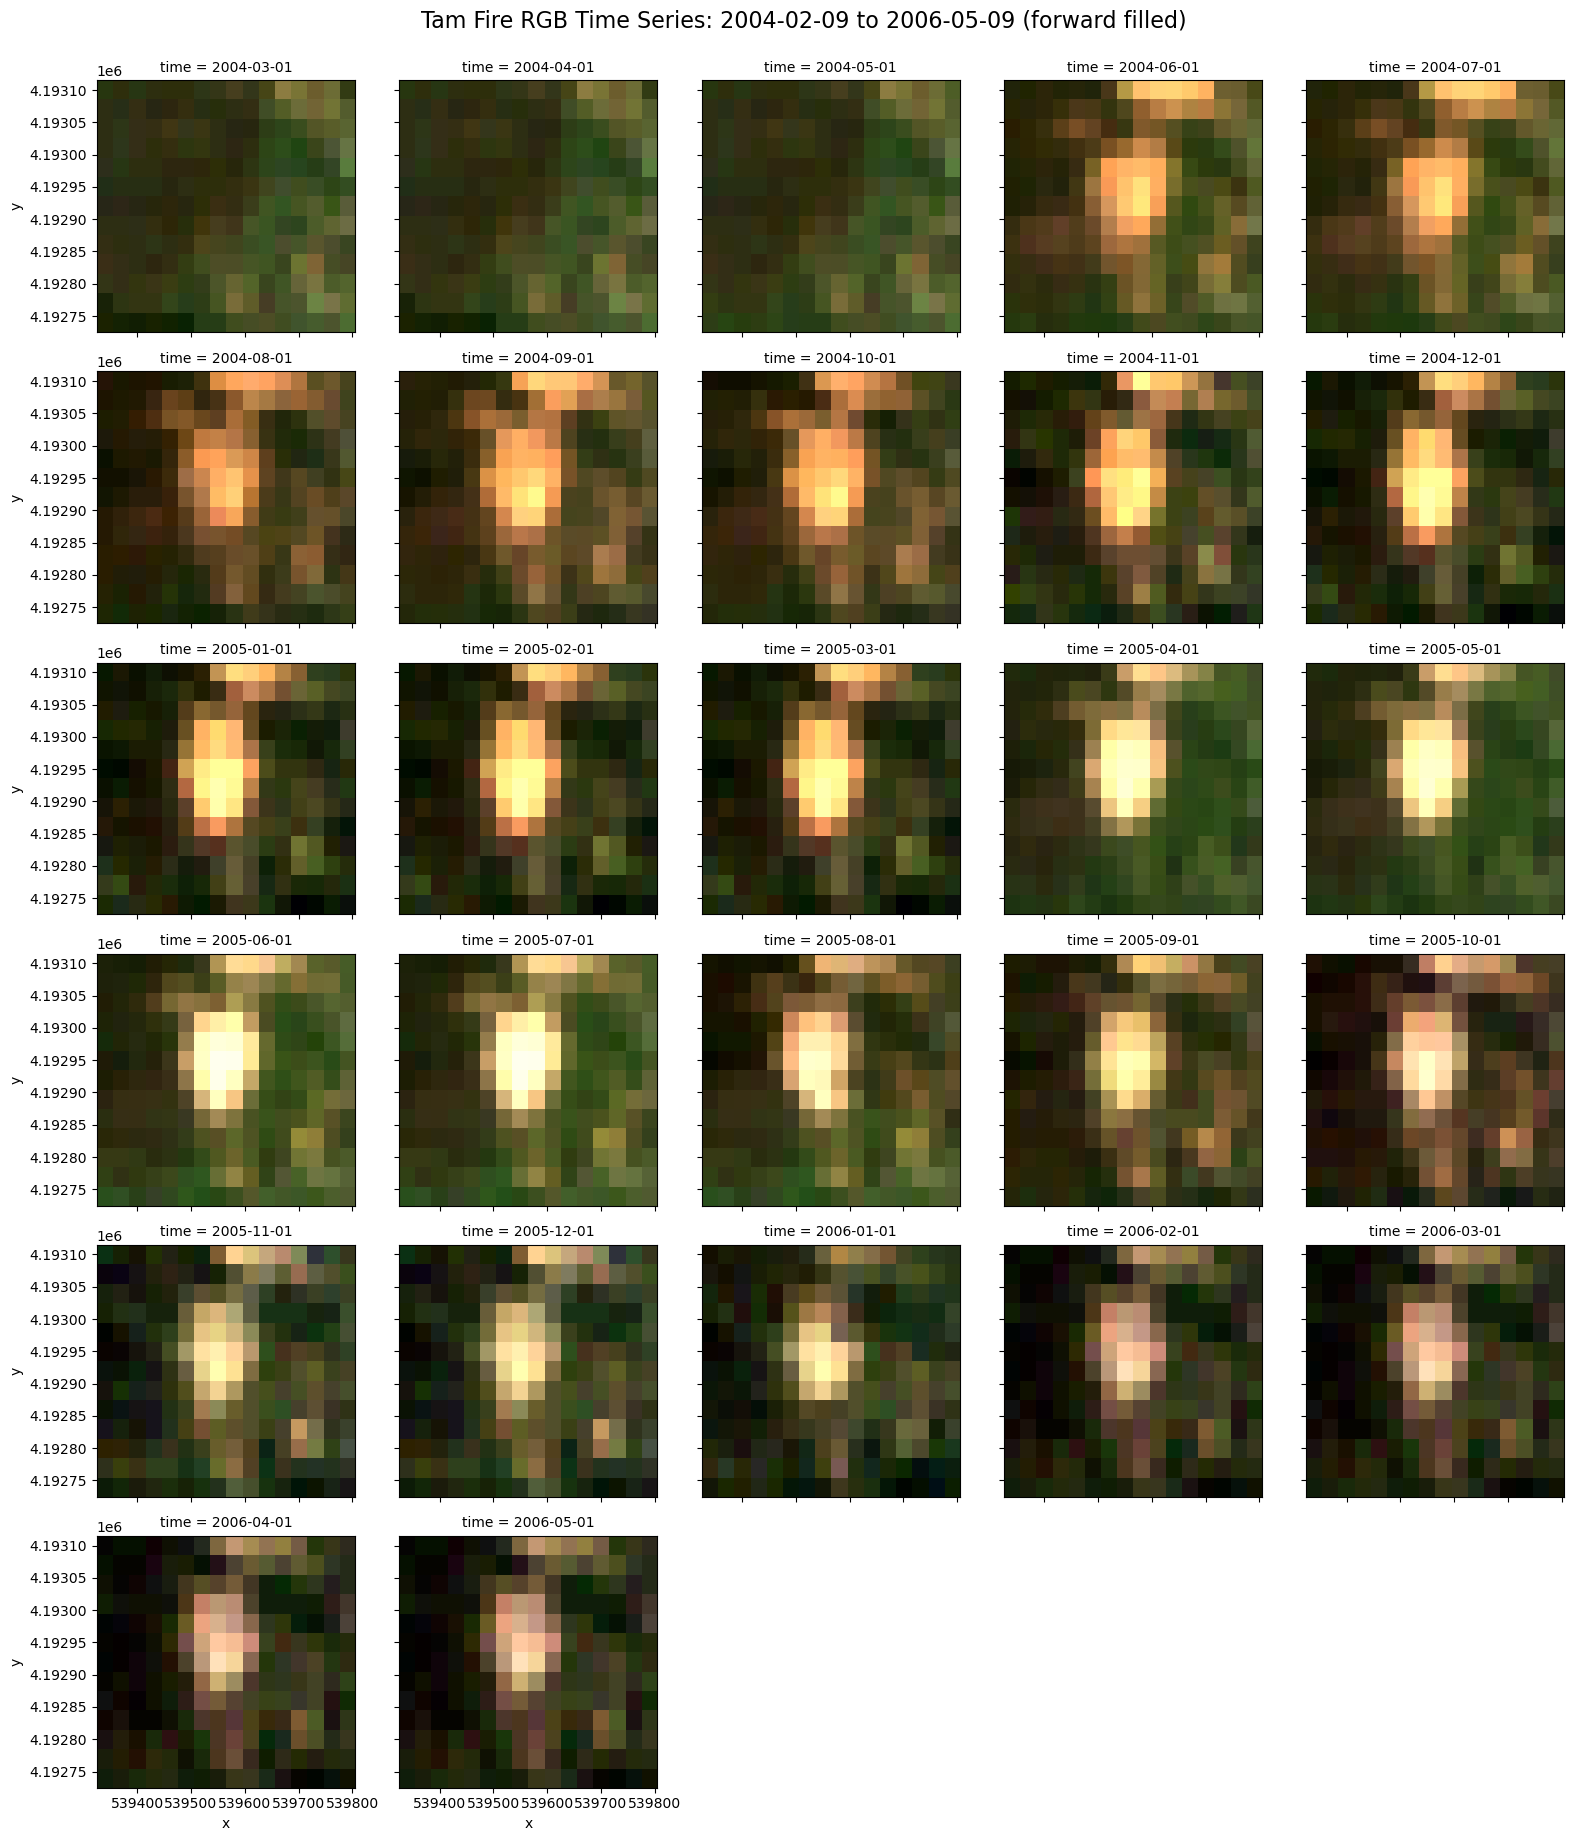

In [19]:
Fire_Area_TS(10,'RGB',True)

In [20]:
# This function creates a GIF of fire specified by index
# This is not running for some reason (18 DEC 2023 11:36 PST)

def Fire_Area_GIF(index, data_type, FPS):
    # Get fire information by index
    row = Fires32610.iloc[index]
    fire_name = row['FIRE_NAME']
    fire_breakout_time = pd.to_datetime(row['ALARM_DATE'])
    
    # Set the time range based on the ALARM date
    start_time = fire_breakout_time - pd.DateOffset(months=3)
    end_time = fire_breakout_time + pd.DateOffset(months=24)
    
    # Get 'bounding_box' as GeoPandas geometry
    bounding_box = row['bounding_box']
    bounding_box_geojson = geojson.dumps(bounding_box.__geo_interface__)
    bboxClipGeometry = [geojson.loads(bounding_box_geojson)]
    
    # Clip the xarray dataarray with the fire and vegetation geometries
    if data_type == 'NBR':
        bboxClip = monthlyNBR.rio.clip(bboxClipGeometry)
    elif data_type == 'RGB':
        bboxClip = monthlyRGB.rio.clip(bboxClipGeometry)
    else:
        raise ValueError("Invalid data_type. Use 'NBR' or 'RGB'.")
    
    # Select the desired time range
    bboxTimeClip = bboxClip.sel(time=slice(start_time, end_time))
    # Persist the Dask array
    bboxTS = bboxTimeClip.persist()
    # Fill NaN values and calculate mean
    bboxCleaned = bboxTS.ffill("time")[0:]
    
    #dgif(bboxTimeClip, fps=FPS).compute()
    gif = dgif(bboxCleaned, fps=FPS, date_position="lr").compute()

    gif

In [21]:
# Set Variables for fire index, NBR or RGB, and frames per second
# Call function
Fire_Area_GIF(12, 'NBR', FPS =1)

In [16]:
# Run to get an list with index number for each fire
Fires32610

YEAR_ STATE AGENCY UNIT_ID              FIRE_NAME   INC_NUM  ALARM_DATE  \
0   2017    CA    CDF     LNU                     37  00002957  2017-10-09   
1   2020    CA    CDF     CZU  CZU LIGHTNING COMPLEX  00005205  2020-08-16   
2   2021    CA    CDF     CZU                FREEDOM  00000489  2021-01-19   
3   2020    CA    CDF     LNU                  GLASS  00015497  2020-09-27   
4   2004    CA    CDF     SCU                HIGHWAY  00003485  2004-06-25   
5   2019    CA    CDF     LNU                KINCADE  00019376  2019-10-23   
6   2013    CA    CDF     LNU              LAKEVILLE  00006147  2013-07-26   
7   2017    CA    CDF     LNU                   NUNS  00010049  2017-10-08   
8   2017    CA    CDF     LNU               PRESSLEY  00010049  2017-10-08   
9   2022    CA    CDF     SCU                 SCENIC  00004548  2022-06-23   
10  2004    CA    NPS     GNP                    TAM  00000003  2004-05-09   
11  2008    CA    CDF     CZU                TRABING    005581  2008-06-20   
12  2017    CA    CDF     LNU                  TUBBS  00010045  2017-10-08   

     CONT_DATE  CAUSE                                           COMMENTS  ...  \
0   2017-10-16     11  LFB8.  DIGITIZED FROM DIGITALGLOBE (MAXAR) IMA...  ...   
1   2020-09-24      1                                                NaN  ...   
2   2021-01-22     11                                                NaN  ...   
3   2020-10-20     14                                         J. Baldwin  ...   
4   2004-06-28      2                                                NaN  ...   
5   2019-11-10     11                                                NaN  ...   
6   2013-07-27      2                                                NaN  ...   
7   2017-10-31     14  Nuns,Partrick, Adobe, Norrbom and Pressley mer...  ...   
8   2017-10-15     14                                   Merged into Nuns  ...   
9   2022-06-23     10                                                NaN  ...   
10  2004-05-18     14                                                NaN  ...   
11  2008-06-22     10                            75 structures destroyed  ...   
12  2017-11-01     14                                                NaN  ...   

    C_METHOD  OBJECTIVE  FIRE_NUM             COMPLEX_NA COMPLEX_IN  \
0          4          1       NaN                    NaN        NaN   
1          7          1       NaN  CZU LIGHTNING COMPLEX   00005205   
2          1          1       NaN                    NaN        NaN   
3          7          1       NaN                    NaN        NaN   
4          1          1  00000181                    NaN        NaN   
5          1          1       NaN                    NaN        NaN   
6          2          1       NaN                    NaN        NaN   
7          3          1       NaN   SOUTHERN LNU COMPLEX   00010105   
8          7          1       NaN   SOUTHERN LNU COMPLEX   00010105   
9          1          1       NaN                    NaN        NaN   
10         1          1  00000003                    NaN        NaN   
11         1          1       NaN                    NaN        NaN   
12         3          1       NaN    CENTRAL LNU COMPLEX   00010104   

                                 IRWINID     Shape_Leng    Shape_Area  \
0   F570C977-2D96-4BB0-A146-52D1A32FA87D   46336.050945  1.057459e+07   
1                                    NaN  255052.193260  5.523185e+08   
2                                    NaN    4130.554410  2.112959e+05   
3                                    NaN  272074.173454  4.470432e+08   
4                                    NaN   10317.778914  4.080267e+06   
5                                    NaN  238568.856409  5.171126e+08   
6                                    NaN    8412.064209  1.166756e+06   
7                                    NaN  305483.095957  3.680012e+08   
8                                    NaN   22361.236288  5.220480e+06   
9   0ef3aa7b-6f57-4b9d-9ffc-07de6bfd0673    5501.8

In [43]:
# Troubleshooting why the GIF creation code doesnt work as a function, as above
# This code runs

index= 12 # Set the index for the fire you want to test
data_type = "RGB" # Set to "NBR" or "RGB"
FPS = 2 # Frames per second

# Get fire information by index
row = Fires32610.iloc[index]
fire_name = row['FIRE_NAME']
fire_breakout_time = pd.to_datetime(row['ALARM_DATE'])

# Set the time range based on the ALARM date
start_time = fire_breakout_time - pd.DateOffset(months=3)
end_time = fire_breakout_time + pd.DateOffset(months=24)

# Get 'bounding_box' as GeoPandas geometry
bounding_box = row['bounding_box']
bounding_box_geojson = geojson.dumps(bounding_box.__geo_interface__)
bboxClipGeometry = [geojson.loads(bounding_box_geojson)]

# Clip the xarray dataarray with the fire and vegetation geometries
if data_type == 'NBR':
    bboxClip = monthlyNBR.rio.clip(bboxClipGeometry)
elif data_type == 'RGB':
    bboxClip = monthlyRGB.rio.clip(bboxClipGeometry)
else:
    raise ValueError("Invalid data_type. Use 'NBR' or 'RGB'.")

# Select the desired time range
bboxTimeClip = bboxClip.sel(time=slice(start_time, end_time))

# Fill NaN values
bboxCleaned = bboxTimeClip.ffill("time")[0:]

# use dask gif to turn time series into gif
gif = dgif(bboxCleaned, fps=FPS, date_position="lr").compute()
# I'd love to add outline of fire perimeter, but this is not working
#gif.add_geojson(fire_dict)


/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


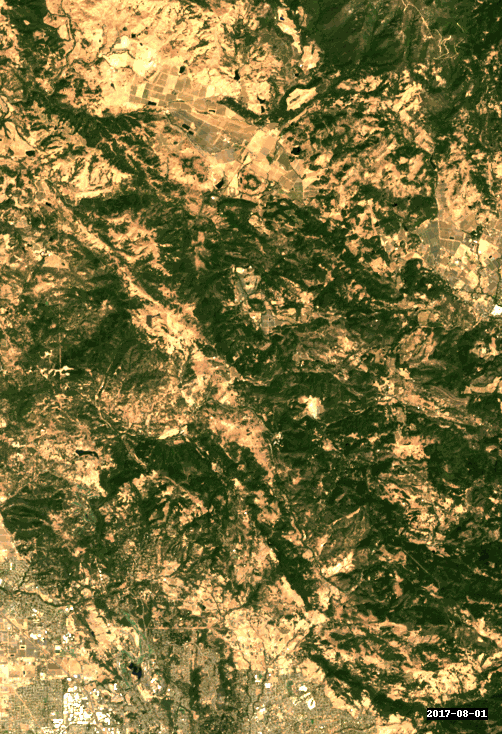

In [44]:
gif

In [55]:
# Attempt to extract fire perimeters to be added to GIFs
fireOutline = row['geometry']

fire_df = gpd.GeoDataFrame(geometry=[fireOutline])
type(fire_df)
fire_df.set_crs(4326)
fire_json = fire_df.to_json()
fire_dict = json.loads(fire_json)["features"][0]["geometry"]
fire_dict

{'type': 'MultiPolygon',
 'coordinates': [[[[537975.3701078886, 4253801.100608366],
    [537982.1944503807, 4253786.519380843],
    [537964.5296904055, 4253775.389600249],
    [537944.6462170985, 4253767.360277831],
    [537933.637589027, 4253746.928755954],
    [537931.4701446738, 4253715.1510052495],
    [537934.8327082444, 4253676.149733702],
    [537940.6654463449, 4253659.423004007],
    [537956.0619286184, 4253641.942849005],
    [537954.4487397575, 4253626.0371486405],
    [537919.0005825043, 4253640.767654155],
    [537895.7483028307, 4253653.575074389],
    [537879.0814711959, 4253662.755302704],
    [537864.6484981437, 4253673.993630246],
    [537852.2577325462, 4253674.545564174],
    [537851.3028205147, 4253675.0899356855],
    [537848.3742843391, 4253676.968017537],
    [537846.5298081444, 4253679.783385548],
    [537846.494315312, 4253679.861148027],
    [537850.5433411207, 4253691.792538054],
    [537851.5243027165, 4253692.943838632],
    [537854.085288591, 4253692.7417